# Seleccion y entrenamiento del modelo final

## Librerias

In [84]:
import pandas as pd
import numpy as np
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
# ensamble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
# Metricas
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support

## Bajamos los datos y los visualizamos 

In [23]:
df = pd.read_csv("CleanStar.csv")
df.head()

,Vmag,Plx,B-V,MagA,Clase
0,7.27,2.52,0.024,14.277002,0.0
1,9.09,13.17,0.653,19.687930,0.0
2,7.03,3.79,-0.018,14.923197,0.0
3,8.02,3.79,1.220,15.913197,1.0
4,8.00,-0.03,1.894,5.385606,1.0


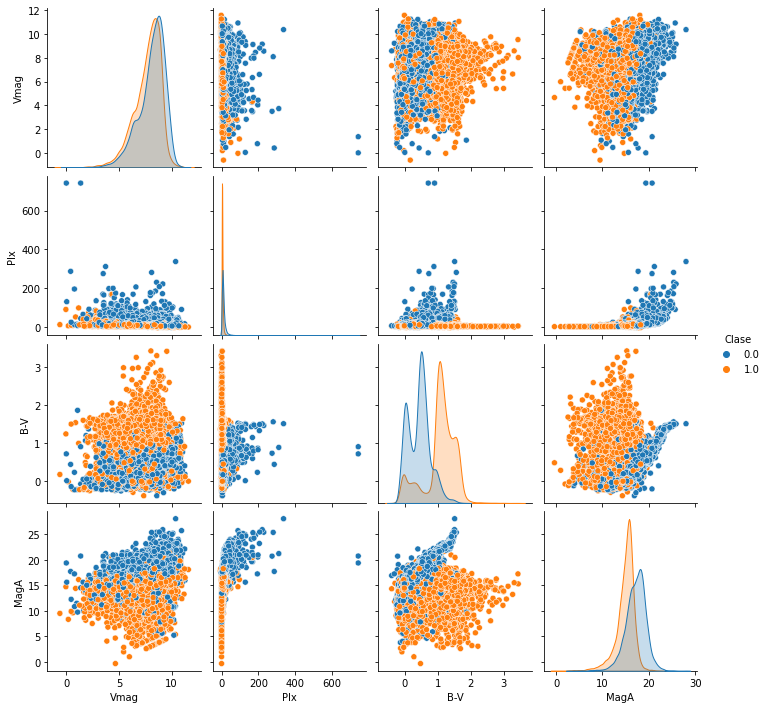

In [24]:
sns.pairplot(df, hue='Clase')

In [25]:
X_big = np.array(df[['Vmag','Plx','B-V','MagA']].values)
X_small = np.array(df[['B-V','MagA']].values)
Y = np.array(df['Clase'].values)

## Hacemos un analisis del desempeño de los diferentes modeles

In [26]:
def best_lr(X_train, Y_train, X_test, Y_test):
    solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    best_solver = ''
    best_score_LR = 0
    for i in solvers:
        LogReg = LogisticRegression(solver=i)
        LogReg.fit(X_train, Y_train)
        score = LogReg.score(X_test,Y_test)
        if score > best_score_LR:
            best_score_LR = score
            best_solver = i
    print('El mejor solver para la regresion logistica es {}, con un accuracy en los datos de prueba de {}%.'.format(best_solver, best_score_LR*100))
    return best_solver

In [27]:
def best_knn(X_train, Y_train, X_test, Y_test):
    n_neigh = 15
    K_best = 0
    Score_best = 0

    for i in range(1,n_neigh):
        KNN = KNeighborsClassifier(n_neighbors=i)
        KNN.fit(X_train,Y_train)
        Y_pred = KNN.predict(X_test)
        if KNN.score(X_test,Y_test) > Score_best:
            Score_best = KNN.score(X_test,Y_test)
            K_best = i
    print('El mejor numero de vecinos para K-NN es {}, con un accuracy en los datos de prueba de {}%.'.format(K_best, (Score_best*100)))
    return K_best

In [44]:
def models(X,Y,best_solver,K_best):
    # prepare configuration for cross validation test harness
    seed = 7
    # prepare models
    models = []
    models.append(('LR', LogisticRegression(solver=best_solver)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('SVM', SVC())) #takes longer, comment if needed 2mins aprox
    models.append(('KNN', KNeighborsClassifier(n_neighbors=K_best)))
    models.append(('RFC', RandomForestClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('HGBC', HistGradientBoostingClassifier()))
    models.append(('NN', MLPClassifier(hidden_layer_sizes=(64,32), max_iter=300)))
    # evaluate each model in turn
    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
        cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

El mejor solver para la regresion logistica es newton-cg, con un accuracy en los datos de prueba de 88.11485964460468%.
El mejor numero de vecinos para K-NN es 12, con un accuracy en los datos de prueba de 88.41102240535669%.
LR: 0.880453 (0.004622)
LDA: 0.881715 (0.004687)
SVM: 0.883389 (0.004842)
KNN: 0.881355 (0.006579)
RFC: 0.876642 (0.005459)
ETC: 0.872779 (0.005057)
ABC: 0.878341 (0.005930)
GBC: 0.884342 (0.005376)
HGBC: 0.885166 (0.005035)
NN: 0.884728 (0.005120)


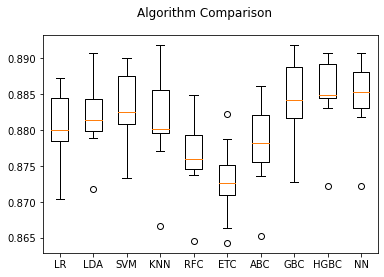

In [45]:
# Dividimos datos
X_trainB, X_testB, Y_trainB, Y_testB = train_test_split(X_big, Y, test_size=0.2, random_state=42)
# Normalizamos
scalerB = StandardScaler().fit(X_trainB)
X_trainB = scalerB.transform(X_trainB)
X_testB = scalerB.transform(X_testB)
X_big = scalerB.transform(X_big)
# modelos
best_solver = best_lr(X_trainB, Y_trainB, X_testB, Y_testB)
K_best = best_knn(X_trainB, Y_trainB, X_testB, Y_testB)
models(X_big,Y,best_solver,K_best)

El mejor solver para la regresion logistica es newton-cg, con un accuracy en los datos de prueba de 88.34663919649756%.
El mejor numero de vecinos para K-NN es 12, con un accuracy en los datos de prueba de 88.06335307751738%.
LR: 0.881226 (0.004739)
LDA: 0.881638 (0.003987)
SVM: 0.881741 (0.004472)
KNN: 0.879217 (0.004526)
RFC: 0.864615 (0.004793)
ETC: 0.857559 (0.003593)
ABC: 0.877363 (0.006103)
GBC: 0.882076 (0.005114)
HGBC: 0.883389 (0.004594)
NN: 0.882101 (0.004632)


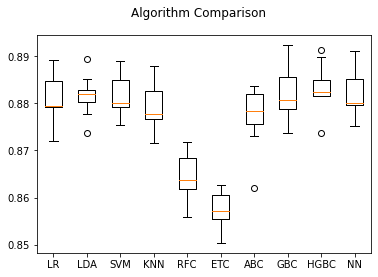

In [46]:
# Dividimos datos
X_trainS, X_testS, Y_trainS, Y_testS = train_test_split(X_small, Y, test_size=0.2, random_state=42)
# Normalizamos
scalerS = StandardScaler().fit(X_trainS)
X_trainS = scalerS.transform(X_trainS)
X_testS = scalerS.transform(X_testS)
X_small = scalerS.transform(X_small)
# Modelos
best_solver = best_lr(X_trainS, Y_trainS, X_testS, Y_testS)
K_best = best_knn(X_trainS, Y_trainS, X_testS, Y_testS)
models(X_small,Y,best_solver,K_best)

Podemos ver que los mejores modelos son los de HGBD y NN con todos los features vamos a crear un clasificador por votos con estos 2 modelos

## Creamos un modelo por votos con los mejores modelos

In [65]:
clf1 = HistGradientBoostingClassifier()
clf2 = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=300)
eclf = VotingClassifier(estimators=[('HGBD', clf1), ('NN', clf2)], voting='soft')

In [70]:
kfold = model_selection.KFold(n_splits=10, shuffle=True)
cv_results = model_selection.cross_val_score(eclf, X_big, Y, cv=kfold, scoring='accuracy')

mean:  0.8848570692763328 Std: 0.004404413860755918


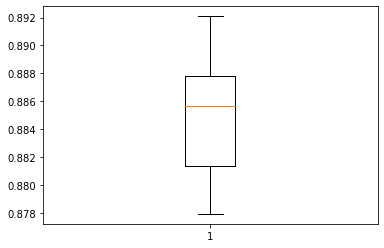

In [71]:
print('mean: ',cv_results.mean(), 'Std:', cv_results.std())
plt.boxplot(cv_results);

In [68]:
eclf.fit(X_trainB, Y_trainB)
acc = eclf.score(X_testB, Y_testB)
print(acc)

0.8883595158382693


## Evaluamos que tan bien se desempeña este modelo

In [78]:
y_pred = eclf.predict(X_testB)

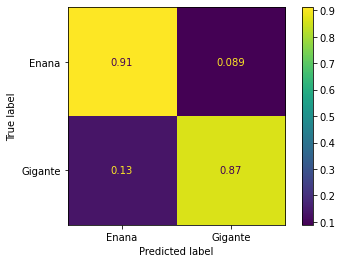

In [77]:
plot_confusion_matrix(eclf, X_testB, Y_testB, display_labels=['Enana','Gigante'],normalize='true');

In [81]:
Metrics = precision_recall_fscore_support(Y_testB, y_pred, average='macro')
print(f'El accuracy en los datos de prueba es: {acc:0.4f}')
print(f'La precision en los datos de prueba es: {Metrics[0]:0.4f}')
print(f'El recall en los datos de prueba es: {Metrics[1]:0.4f}')
print(f'El F1 en los datos de prueba es: {Metrics[2]:0.4f}')

El accuracy en los datos de prueba es: 0.8884
La precision en los datos de prueba es: 0.8892
El recall en los datos de prueba es: 0.8883
El F1 en los datos de prueba es: 0.8883


## Guardamos el modelo

In [85]:
dump(eclf, 'VotedClasifier.joblib')

['VotedClasifier.joblib']

In [86]:
dump(scalerB, 'Scaler.joblib')

['Scaler.joblib']